In [22]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from G_A_layer_tuning import *
from fine_tuning import *

In [11]:
def load_urbansound8k(load_path):
    '''
    loaded = np.load('파일명.npz', allow_pickle=True)
    (128, 173, 1)
    '''

    train_path = os.path.join(load_path, 'fold1train.npy')
    test_path = os.path.join(load_path, 'fold1test.npy')

    train_data = np.load(train_path, allow_pickle=True)
    test_data = np.load(test_path, allow_pickle=True)

    x_train = train_data[:, -1]
    y_train = train_data[:, 1]
    x_test = test_data[:, -1]
    y_test = test_data[:, 1]

    x_train = np.stack(x_train, axis=0)
    x_test = np.stack(x_test, axis=0)

    x_train = x_train[...,np.newaxis]
    x_test = x_test[...,np.newaxis]
    y_train = y_train.reshape((-1,))
    y_test = y_test.reshape((-1,))

    # 배열의 원소 개수만큼 인덱스 배열을 만든 후
    # 무작위로 뒤섞어 줍니다.
    idx_train = np.arange(x_train.shape[0])
    idx_test = np.arange(x_test.shape[0])
    # print(idx)
    np.random.shuffle(idx_train)
    np.random.shuffle(idx_test)

    x_train_shuffle = x_train[idx_train]
    y_train_shuffle = y_train[idx_train]
    x_test_shuffle = x_test[idx_test]
    y_test_shuffle = y_test[idx_test]

    # TensorFlow에서 읽을 수 있는 np.astype으로 변경
    x_train = np.asarray(x_train_shuffle).astype(np.float64)
    y_train = np.asarray(y_train_shuffle).astype(np.int64)
    x_test = np.asarray(x_test_shuffle).astype(np.float64)
    y_test = np.asarray(y_test_shuffle).astype(np.int64)

    print('Train/Test Dataset Shape')
    print('x_train shape is ', x_train.shape)
    print('y_train shape is ', y_train.shape)
    print('x_test shape is ', x_test.shape)
    print('y_test shape is ', y_test.shape)

    return x_train, y_train, x_test, y_test

In [12]:
def load_hospitalalarmsound(load_path):
    '''
    loaded = np.load('파일명.npz')
    loaded['spectrogram']
    loaded['Mel_spectrogram']
    loaded['Log_Mel_spectrogram']
    loaded['mfcc']
    loaded['delta_mfcc']
    '''

    for idx, file in enumerate(os.listdir(load_path)):
        filepath = os.path.join(load_path, file)
        loaded = np.load(filepath)
        # print('class number :',idx, file[:-4])
        x = loaded['Log_Mel_spectrogram']
        y = np.zeros((x.shape[0],1), dtype=np.int8)
        y = y + idx
        # print(x.shape)
        # print(y.shape)
        ratio = round(x.shape[0]*0.2)   # 각 클래스별 나누는 비율
        flag = x.shape[0]-ratio

        if idx == 0:
            x_train = x[:flag]
            y_train = y[:flag]
            x_test = x[flag:]
            y_test = y[flag:]
        else:
            x_train = np.vstack((x_train, x[:flag]))
            y_train = np.vstack((y_train, y[:flag]))
            x_test = np.vstack((x_test, x[flag:]))
            y_test = np.vstack((y_test, y[flag:]))

    x_train = x_train[...,np.newaxis]
    x_test = x_test[...,np.newaxis]
    y_train = y_train.reshape((-1,))
    y_test = y_test.reshape((-1,))

    # 배열의 원소 개수만큼 인덱스 배열을 만든 후 
    # 무작위로 뒤섞어 줍니다. 
    idx_train = np.arange(x_train.shape[0])
    idx_test = np.arange(x_test.shape[0])
    # print(idx)
    np.random.shuffle(idx_train)
    np.random.shuffle(idx_test)

    x_train_shuffle = x_train[idx_train]
    y_train_shuffle = y_train[idx_train]
    x_test_shuffle = x_test[idx_test]
    y_test_shuffle = y_test[idx_test]

    # TensorFlow에서 읽을 수 있는 np.astype으로 변경
    x_train = np.asarray(x_train_shuffle).astype(np.float64)
    y_train = np.asarray(y_train_shuffle).astype(np.int64)
    x_test = np.asarray(x_test_shuffle).astype(np.float64)
    y_test = np.asarray(y_test_shuffle).astype(np.int64)

    print('Train/Test Dataset Shape')
    print('x_train shape is ', x_train.shape)
    print('y_train shape is ', y_train.shape)
    print('x_test shape is ', x_test.shape)
    print('y_test shape is ', y_test.shape)

    return x_train, y_train, x_test, y_test

In [13]:
# Parameters for G.A.
num_of_class = 8            # Number of Dataset classes
freezing_layer_flag = 0     # How many layers to freeze in the pretrained model?
type = 'vgg'                # Pretrained model type : 'vgg', 'resnet', 'mobilenet', 'efficientnet'

N_POPULATION = 4            # Number of Populations by Generation in Genetic Algorithm
# N_BEST = 2
# N_CHILDREN = 2
PROB_MUTATION = 0.04        # Mutation Probability of Genetic Algorithms

lr = 0.0001                 # Learning rate for training pretrained models in Genetic Algorithm
epoch = 4                   # Number of epochs for training pretrained models in Genetic Algorithm
batch_size = 64             # Number of batch size for training pretrained models in Genetic Algorithm

In [14]:
# Load dataset for hospitalAlarmsound
load_path = 'D:\GH\Audio\dataset\preprocess_data\hospital_alarm\zero_pad_preprocess'        # HospitalAlarmSound : num_of_class=8
save_path = 'D:\\GH\\Audio\\GA\\test\\pickle_data\\HospitalAlarmSound\\0823_vgg'            # Path to store result metadata
dataset = load_hospitalalarmsound(load_path)                                                # Load HospitalAlarmSound dataset

# Load dataset for urbansound8k
# load_path = 'D:\GH\Audio\dataset\\UrbanSound8K\\audio\\np_data'                           # UrbanSound8K : num_of_class=10
# save_path = 'D:\\GH\\Audio\\GA\\test\\pickle_data\\UrbanSound8K\\0824_vgg'
# dataset = load_urbansound8k(load_path)                                                    # Load UrbanSound8K dataset

x_train, y_train, x_test, y_test = dataset
input_shape = (x_train.shape[1], x_train.shape[2])
'''
x_train : train image(batch, width, height, channel=1)
x_test : train label(class)
y_train : validation image(batch, width, height, channel=1)
y_test : validation label(class)
''' 

Train/Test Dataset Shape
x_train shape is  (456, 128, 311, 1)
y_train shape is  (456,)
x_test shape is  (113, 128, 311, 1)
y_test shape is  (113,)


In [15]:
run_G_A(x_train, y_train, x_test, y_test, epoch, batch_size, num_of_class, 
    freezing_layer_flag, type, save_path, 5, N_POPULATION, PROB_MUTATION, lr, False)
'''
The final metadata is stored in the specified path 
by performing layer tuning of the pre-trained model 
based on the Genetic Algorithm on the input data.
return Numpy Array of (accuracy, metadata)
''' 

===== Initializaton #0	Genome #0 : Fitness 0 =====
===== Initializaton #0	Genome #1 : Fitness 0 =====
===== Initializaton #0	Genome #2 : Fitness 0 =====
===== Initializaton #0	Genome #3 : Fitness 0 =====
====================== Generaton #1	 START ======================
Epoch 1/4
8/8 [==============================] - 21s 803ms/step - loss: 1.2179 - accuracy: 0.6974 - val_loss: 0.0569 - val_accuracy: 1.0000
Epoch 2/4
8/8 [==============================] - 3s 372ms/step - loss: 0.0202 - accuracy: 0.9934 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 3/4
8/8 [==============================] - 3s 372ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 9.0691e-05 - val_accuracy: 1.0000
Epoch 4/4
8/8 [==============================] - 3s 371ms/step - loss: 1.1590e-04 - accuracy: 1.0000 - val_loss: 4.9575e-05 - val_accuracy: 1.0000
Generation #1, Genome #0, Fitness: [1.0, 1.0, 1.0, 1.0], Best Fitness: 1.0
Epoch 1/4
8/8 [==============================] - 4s 396ms/step - loss: 1.1642 - accura

In [16]:
G_A_best_bool_arr = load_best_picklefile(save_path)[1]
'''
load_best_picklefile(save_path) : Loads the best metadata within the entire pickle files from the specified path.
load_picklefile(filename) : Loads the best metadata from the specified pickle file.
''' 

(10, 1) (10, 19)


In [17]:
# Parameters for test
type ='vgg'                                             # Pretrained model type : 'vgg', 'resnet', 'mobilenet', 'efficientnet'
freezing_layer_flag = 0                                 # How many layers to freeze in the pretrained model?
num_of_class = 8                                        # Number of Dataset classes
learning_rate = 0.0001                                  # Learning rate for training pretrained models in fine-tuning
one_hot_encoding = False                                # One-Hot Encoding Types of Dataset Classes
epochs=30                                               # Number of epochs for training pretrained models in fine-tuning
batch_size=32                                           # Number of batch size for training pretrained models in fine-tuning
checkpoint_path='model_checkpoints_best/checkpoint'     # Checkpoint storage path for fine-tuning results

In [19]:
Finetuned_vgg = Finetuing_Pretrained_Model(G_A_best_bool_arr, input_shape, freezing_layer_flag, type)
'''
Adjusting the layers of a pre-trained model based on loaded metadata.
.forward : Create a tuned pre-trained model.
.train_model : Returning history object after fine-tuning the model.
.load_model : Load fine-tuning model from best-checkpoints.
.eval_model : Model evaluation on input data.
''' 
model = Finetuned_vgg.forward(num_of_class, learning_rate, one_hot_encoding)
history = Finetuned_vgg.train_model(model, x_train, y_train, x_test, y_test, epochs, batch_size, checkpoint_path)

Model: "vgg_pretrained_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 128, 311, 1)]     0         
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 311, 3)       6         
                                                                 
 vgg16 (Functional)          (None, 4, 9, 512)         14714688  
                                                                 
 flatten_25 (Flatten)        (None, 18432)             0         
                                                                 
 dense_25 (Dense)            (None, 8)                 147464    
                                                                 
Total params: 14,862,158
Trainable params: 6,823,630
Non-trainable params: 8,038,528
_________________________________________________________________
Epoch 1/30
15/15 [=========

NameError: name 'accuracy_result' is not defined

In [26]:
def accuracy_result(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Finetuning preTrained model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

def loss_result(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Finetuning preTrained model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

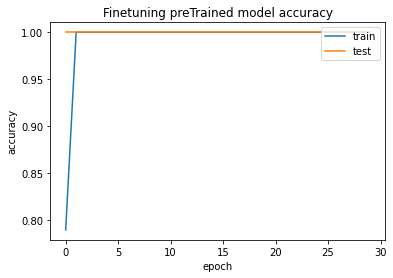

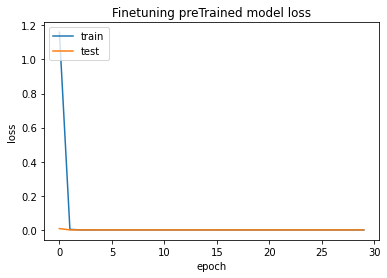

In [27]:
accuracy_result(history)
loss_result(history)

In [25]:
loaded_vgg = Finetuing_Pretrained_Model(None, input_shape, freezing_layer_flag, type)
model = loaded_vgg.forward(num_of_class, learning_rate, one_hot_encoding)
model = loaded_vgg.load_model(model, checkpoint_path)
loss, acc = loaded_vgg.eval_model(model, x_test, y_test, verbose=2)

Model: "vgg_pretrained_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 128, 311, 1)]     0         
                                                                 
 conv2d_26 (Conv2D)          (None, 128, 311, 3)       6         
                                                                 
 vgg16 (Functional)          (None, 4, 9, 512)         14714688  
                                                                 
 flatten_26 (Flatten)        (None, 18432)             0         
                                                                 
 dense_26 (Dense)            (None, 8)                 147464    
                                                                 
Total params: 14,862,158
Trainable params: 14,862,158
Non-trainable params: 0
_________________________________________________________________
57/57 [===========================